<div style="text-align: center; font-family: Arial, sans-serif;">
    <h1 style="font-size: 30px; color: #2196F3;">ALY 6020 : Predictive Analytics</h1>
    <h3 style="font-size: 16px; color: #9C27B0;">Prof. Sudesh Shetty</h3>
    <h3 style="font-size: 16px; color: #9C27B0;">Final Project</h3>
    <h3 style="font-size: 16px; color: #9C27B0;">Topic: Predicting Vehicle Loan Default for a Non-Banking Financial Institution</h3>
    <h3 style="font-size: 14px; color: #9C27B0;">Date: 5th February 2025</h3>
</div>

## Problem Statement:

A non-banking financial institution (NBFI) is experiencing financial losses due to an increasing number of defaults in its vehicle loan portfolio. To mitigate this risk, the company seeks to develop a predictive model that assesses a client's ability to repay loans. By leveraging historical data, the model will help identify high-risk clients and enable data-driven credit decision-making.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time
import pyodbc
print(pyodbc.drivers())
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
from scipy import stats

['SQL Server', 'ODBC Driver 17 for SQL Server', 'SQL Server Native Client RDA 11.0', 'Microsoft Access Driver (*.mdb, *.accdb)', 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)', 'Microsoft Access Text Driver (*.txt, *.csv)', 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)']


## SQL Connection

In [2]:
def create_sql_connection(server, database, username, password, driver='{ODBC Driver 17 for SQL Server}'):
    """
    Establish a connection to a SQL Server database using pyodbc.

    Parameters:
    - server (str): The SQL Server address (e.g., 'localhost' or server IP).
    - database (str): The name of the database you want to connect to.
    - username (str): SQL Server username.
    - password (str): SQL Server password.
    - driver (str): ODBC driver to use. Default is '{ODBC Driver 17 for SQL Server}'.s

    Returns:
    - conn: A pyodbc connection object if successful.
    """
    connection_string = f"""
        DRIVER={driver};
        SERVER={server};
        DATABASE={database};
        UID={username};
        PWD={password};
    """
    try:
        conn = pyodbc.connect(connection_string)
        print("Connection established successfully!")
        return conn
    except Exception as e:
        print(f"Failed to connect to the database. Error: {e}")
        return None

In [3]:
def query_data(conn, query):
    """
    Execute a SQL query and fetch results as a pandas DataFrame.
    
    Parameters:
    - conn: A pyodbc connection object.
    - query (str): The SQL query to be executed.
    
    Returns:
    - data: A pandas DataFrame containing the query result.
    """
    start_time = time.time()  # Start time measurement
    try:
        cursor = conn.cursor()
        cursor.execute(query)
        
        # Fetch all results from the query
        rows = cursor.fetchall()
        
        # Get column names from cursor
        columns = [desc[0] for desc in cursor.description]
        
        # Create a pandas DataFrame from the results
        data = pd.DataFrame.from_records(rows, columns=columns)
        
    except pyodbc.Error as e:
        print(f"Error executing query: {e}")
        return None
    
    finally:
        cursor.close()
    
    end_time = time.time()  # End time measurement
    execution_time = end_time - start_time  # Calculate execution time
    
    # Print the DataFrame and execution time
    print(f"Query executed in: {execution_time:.4f} seconds")
    
    return data  

In [4]:
server = 'ROHIT'     
database = 'NBFIData'  
username = 'rohit_kosamkar'       
password = 'February@2025' 

# Establish connection
conn = create_sql_connection(server, database, username, password)

Connection established successfully!


## Loading Dataset

In [5]:
query = """
select * from dbo.customers as cust
left join dbo.defaulters as def on cust.ID = def.ID
"""

In [6]:
data_temp = query_data(conn, query)
data_temp.shape

Query executed in: 5.2392 seconds


(121799, 41)

In [7]:
# data_temp = pd.read_csv(r"../data/Train_Dataset.csv")

In [34]:
data = data_temp.copy(deep=True)
data.head()

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Occupation,Client_Family_Members,Cleint_City_Rating,Application_Process_Day,Application_Process_Hour,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,ID,Default
0,12138936,20250.0,1.0,0.0,1.0,NaN,0.0,15282.000000,1826.550049,Alone,Service,Graduation,M,Male,CL,Home,0.008575,14162.0,4129.0,7833.0,21.0,0.0,1,0,1,None,2.0,2.0,3.0,10,Yes,Yes,Government,0.563360,0.215068,NaN,NaN,NaN,NaN,12138936,0
1,12215264,13500.0,0.0,0.0,1.0,1.0,0.0,60415.199219,3097.800049,Alone,Retired,Secondary,M,Male,CL,Home,0.009175,22493.0,365243.0,12617.0,5280.0,NaN,1,0,1,None,2.0,2.0,4.0,15,Yes,Yes,XNA,0.711468,0.657508,0.549596,NaN,1687.0,4.0,12215264,0
2,12130547,12150.0,0.0,0.0,0.0,1.0,0.0,16320.150391,1294.650024,Alone,Retired,Secondary,W,Male,CL,Home,0.016612,20507.0,365243.0,2834.0,4053.0,NaN,1,0,0,None,1.0,2.0,NaN,9,Yes,Yes,XNA,0.682285,0.063343,0.080650,NaN,533.0,5.0,12130547,0
3,12106559,15750.0,0.0,1.0,1.0,1.0,NaN,45000.000000,3007.350098,Alone,Service,Secondary,S,Female,CL,Home,0.008866,14536.0,3465.0,5871.0,2594.0,NaN,1,1,0,Laborers,1.0,2.0,2.0,17,Yes,Yes,Other,NaN,0.129861,0.590233,0.1031,340.0,2.0,12106559,0
4,12186490,9000.0,0.0,0.0,0.0,0.0,0.0,22500.000000,2191.949951,Alone,Service,Secondary,S,Male,CL,Home,NaN,NaN,2504.0,6019.0,1191.0,NaN,1,0,0,Sales,1.0,2.0,2.0,11,Yes,Yes,Business Entity Type 2,NaN,0.418630,0.595456,0.0835,2458.0,2.0,12186490,0


In [35]:
# data.describe()

## 1. Cleaning Data

In [36]:
data.columns

Index(['ID', 'Client_Income', 'Car_Owned', 'Bike_Owned', 'Active_Loan',
       'House_Own', 'Child_Count', 'Credit_Amount', 'Loan_Annuity',
       'Accompany_Client', 'Client_Income_Type', 'Client_Education',
       'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type',
       'Client_Housing_Type', 'Population_Region_Relative', 'Age_Days',
       'Employed_Days', 'Registration_Days', 'ID_Days', 'Own_House_Age',
       'Mobile_Tag', 'Homephone_Tag', 'Workphone_Working', 'Client_Occupation',
       'Client_Family_Members', 'Cleint_City_Rating',
       'Application_Process_Day', 'Application_Process_Hour',
       'Client_Permanent_Match_Tag', 'Client_Contact_Work_Tag',
       'Type_Organization', 'Score_Source_1', 'Score_Source_2',
       'Score_Source_3', 'Social_Circle_Default', 'Phone_Change',
       'Credit_Bureau', 'ID', 'Default'],
      dtype='object')

### 1.1 Duplicates Check

In [37]:
data = data.iloc[:,1:]
data.columns

Index(['Client_Income', 'Car_Owned', 'Bike_Owned', 'Active_Loan', 'House_Own',
       'Child_Count', 'Credit_Amount', 'Loan_Annuity', 'Accompany_Client',
       'Client_Income_Type', 'Client_Education', 'Client_Marital_Status',
       'Client_Gender', 'Loan_Contract_Type', 'Client_Housing_Type',
       'Population_Region_Relative', 'Age_Days', 'Employed_Days',
       'Registration_Days', 'ID_Days', 'Own_House_Age', 'Mobile_Tag',
       'Homephone_Tag', 'Workphone_Working', 'Client_Occupation',
       'Client_Family_Members', 'Cleint_City_Rating',
       'Application_Process_Day', 'Application_Process_Hour',
       'Client_Permanent_Match_Tag', 'Client_Contact_Work_Tag',
       'Type_Organization', 'Score_Source_1', 'Score_Source_2',
       'Score_Source_3', 'Social_Circle_Default', 'Phone_Change',
       'Credit_Bureau', 'ID', 'Default'],
      dtype='object')

In [38]:
data.duplicated().sum()

0

### 1.2 Missing Value Check

In [39]:
data['Default'].value_counts()

Default
0    111958
1      9841
Name: count, dtype: int64

In [40]:
# (data.isnull().sum() / len(data)) * 100

In [41]:
# Calculate missing value percentage
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Display the result
missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)
print(missing_percentage)

Own_House_Age                 65.727141
Score_Source_1                56.484864
Social_Circle_Default         51.102226
Client_Occupation             34.001921
Score_Source_3                22.093777
Credit_Bureau                 15.217695
ID_Days                        4.897413
Score_Source_2                 4.682304
Population_Region_Relative     3.989360
Loan_Annuity                   3.959803
Client_Income_Type             3.036971
Client_Housing_Type            3.027118
Phone_Change                   3.006593
House_Own                      3.004130
Application_Process_Hour       3.000846
Loan_Contract_Type             2.995920
Employed_Days                  2.995920
Client_Education               2.990993
Active_Loan                    2.982783
Credit_Amount                  2.981141
Child_Count                    2.978678
Bike_Owned                     2.975394
Registration_Days              2.967184
Type_Organization              2.961436
Client_Income                  2.960615


Dropping Columns with More Than 30% Missing Values.
- Own_House_Age (65.73%)
- Score_Source_1 (56.49%)
- Social_Circle_Default (50.82%)
- Client_Occupation (34%
)

In [42]:
data.drop(columns={'Own_House_Age', 'Score_Source_1', 'Social_Circle_Default', 'Client_Occupation'}, inplace=True)
data.shape

(121799, 36)

#### 1.2.1 Missing Value Treatment

In [43]:
# data.dtypes

In [44]:
# Numerical columns -> Filling with the median value
num_cols = data.select_dtypes(include=['int', 'float']).columns
num_cols

Index(['Client_Income', 'Car_Owned', 'Bike_Owned', 'Active_Loan', 'House_Own',
       'Child_Count', 'Credit_Amount', 'Loan_Annuity',
       'Population_Region_Relative', 'Age_Days', 'Employed_Days',
       'Registration_Days', 'ID_Days', 'Mobile_Tag', 'Homephone_Tag',
       'Workphone_Working', 'Client_Family_Members', 'Cleint_City_Rating',
       'Application_Process_Day', 'Score_Source_2', 'Score_Source_3',
       'Phone_Change', 'Credit_Bureau'],
      dtype='object')

In [45]:
# # Function to check how many target variable records are there for rows with null values
# def missing_vs_target(data, target_col):
#     missing_analysis = {}
    
#     # Loop through each column with missing values
#     for col in data.columns:
#         if data[col].isnull().sum() > 0:  # Only process columns with missing values
#             null_target_count = data[data[col].isnull()][target_col].value_counts()
#             missing_analysis[col] = null_target_count
    
#     # Convert the result into a DataFrame for easier interpretation
#     analysis_df = pd.DataFrame(missing_analysis).T.fillna(0).astype(int)
#     analysis_df.columns = [f"{target_col}=0", f"{target_col}=1"]  # Rename target categories
#     analysis_df["Total Missing"] = data.isnull().sum()
#     return analysis_df

# # Perform analysis
# target_analysis = missing_vs_target(data, target_col="Default")

In [46]:
# target_analysis

In [47]:
def impute_missing_values(data, numerical_cols):
    """
    Impute missing values for numeric columns using mean or median based on business context.

    Parameters:
        data (pd.DataFrame): Input DataFrame with missing values.
        numerical_cols (list): List of numeric column names.

    Returns:
        pd.DataFrame: DataFrame with imputed values.
    """
    # Variables to impute with mean
    mean_cols = [
        "Client_Income", "Credit_Amount", "Loan_Annuity",
        "Population_Region_Relative", "Score_Source_2", "Score_Source_3"
    ]

    # Variables to impute with median
    median_cols = [
        col for col in numerical_cols if col not in mean_cols
    ]

    # Impute mean columns
    for col in mean_cols:
        if col in data.columns:
            data[col].fillna(data[col].mean(), inplace=True)

    # Impute median columns
    for col in median_cols:
        if col in data.columns:
            data[col].fillna(data[col].median(), inplace=True)

    return data

In [48]:
# Apply the function
data = impute_missing_values(data, num_cols)

In [49]:
data['Application_Process_Hour'] = data['Application_Process_Hour'].replace('#NA', pd.NA).fillna('12').astype('int')

In [50]:
# categorical columns-> Filling with the mode value
cat_cols = ['Accompany_Client', 'Client_Income_Type', 'Client_Education',
       'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type',
       'Client_Housing_Type', 'Type_Organization']

In [51]:
def impute_categorical_columns(data, categorical_cols):
    """
    Impute missing values in categorical columns using the mode (most frequent value).

    Parameters:
        data (pd.DataFrame): The DataFrame containing categorical data.
        categorical_cols (list): List of categorical column names.

    Returns:
        pd.DataFrame: DataFrame with imputed categorical values.
    """
    for col in categorical_cols:
        if col in data.columns:
            # Impute missing values with mode (most frequent value)
            mode_value = data[col].mode()[0]  # Get the most frequent value
            data[col].fillna(mode_value, inplace=True)
            print(f"Missing values in '{col}' imputed with mode: {mode_value}")
    
    return data

In [52]:
# Applying the function
data = impute_categorical_columns(data, cat_cols)

Missing values in 'Accompany_Client' imputed with mode: Alone
Missing values in 'Client_Income_Type' imputed with mode: Service
Missing values in 'Client_Education' imputed with mode: Secondary
Missing values in 'Client_Marital_Status' imputed with mode: M
Missing values in 'Client_Gender' imputed with mode: Male
Missing values in 'Loan_Contract_Type' imputed with mode: CL
Missing values in 'Client_Housing_Type' imputed with mode: Home
Missing values in 'Type_Organization' imputed with mode: Business Entity Type 3


In [53]:
data.isna().sum()

Client_Income                 0
Car_Owned                     0
Bike_Owned                    0
Active_Loan                   0
House_Own                     0
Child_Count                   0
Credit_Amount                 0
Loan_Annuity                  0
Accompany_Client              0
Client_Income_Type            0
Client_Education              0
Client_Marital_Status         0
Client_Gender                 0
Loan_Contract_Type            0
Client_Housing_Type           0
Population_Region_Relative    0
Age_Days                      0
Employed_Days                 0
Registration_Days             0
ID_Days                       0
Mobile_Tag                    0
Homephone_Tag                 0
Workphone_Working             0
Client_Family_Members         0
Cleint_City_Rating            0
Application_Process_Day       0
Application_Process_Hour      0
Client_Permanent_Match_Tag    0
Client_Contact_Work_Tag       0
Type_Organization             0
Score_Source_2                0
Score_So

### 1.3 Outlier Check

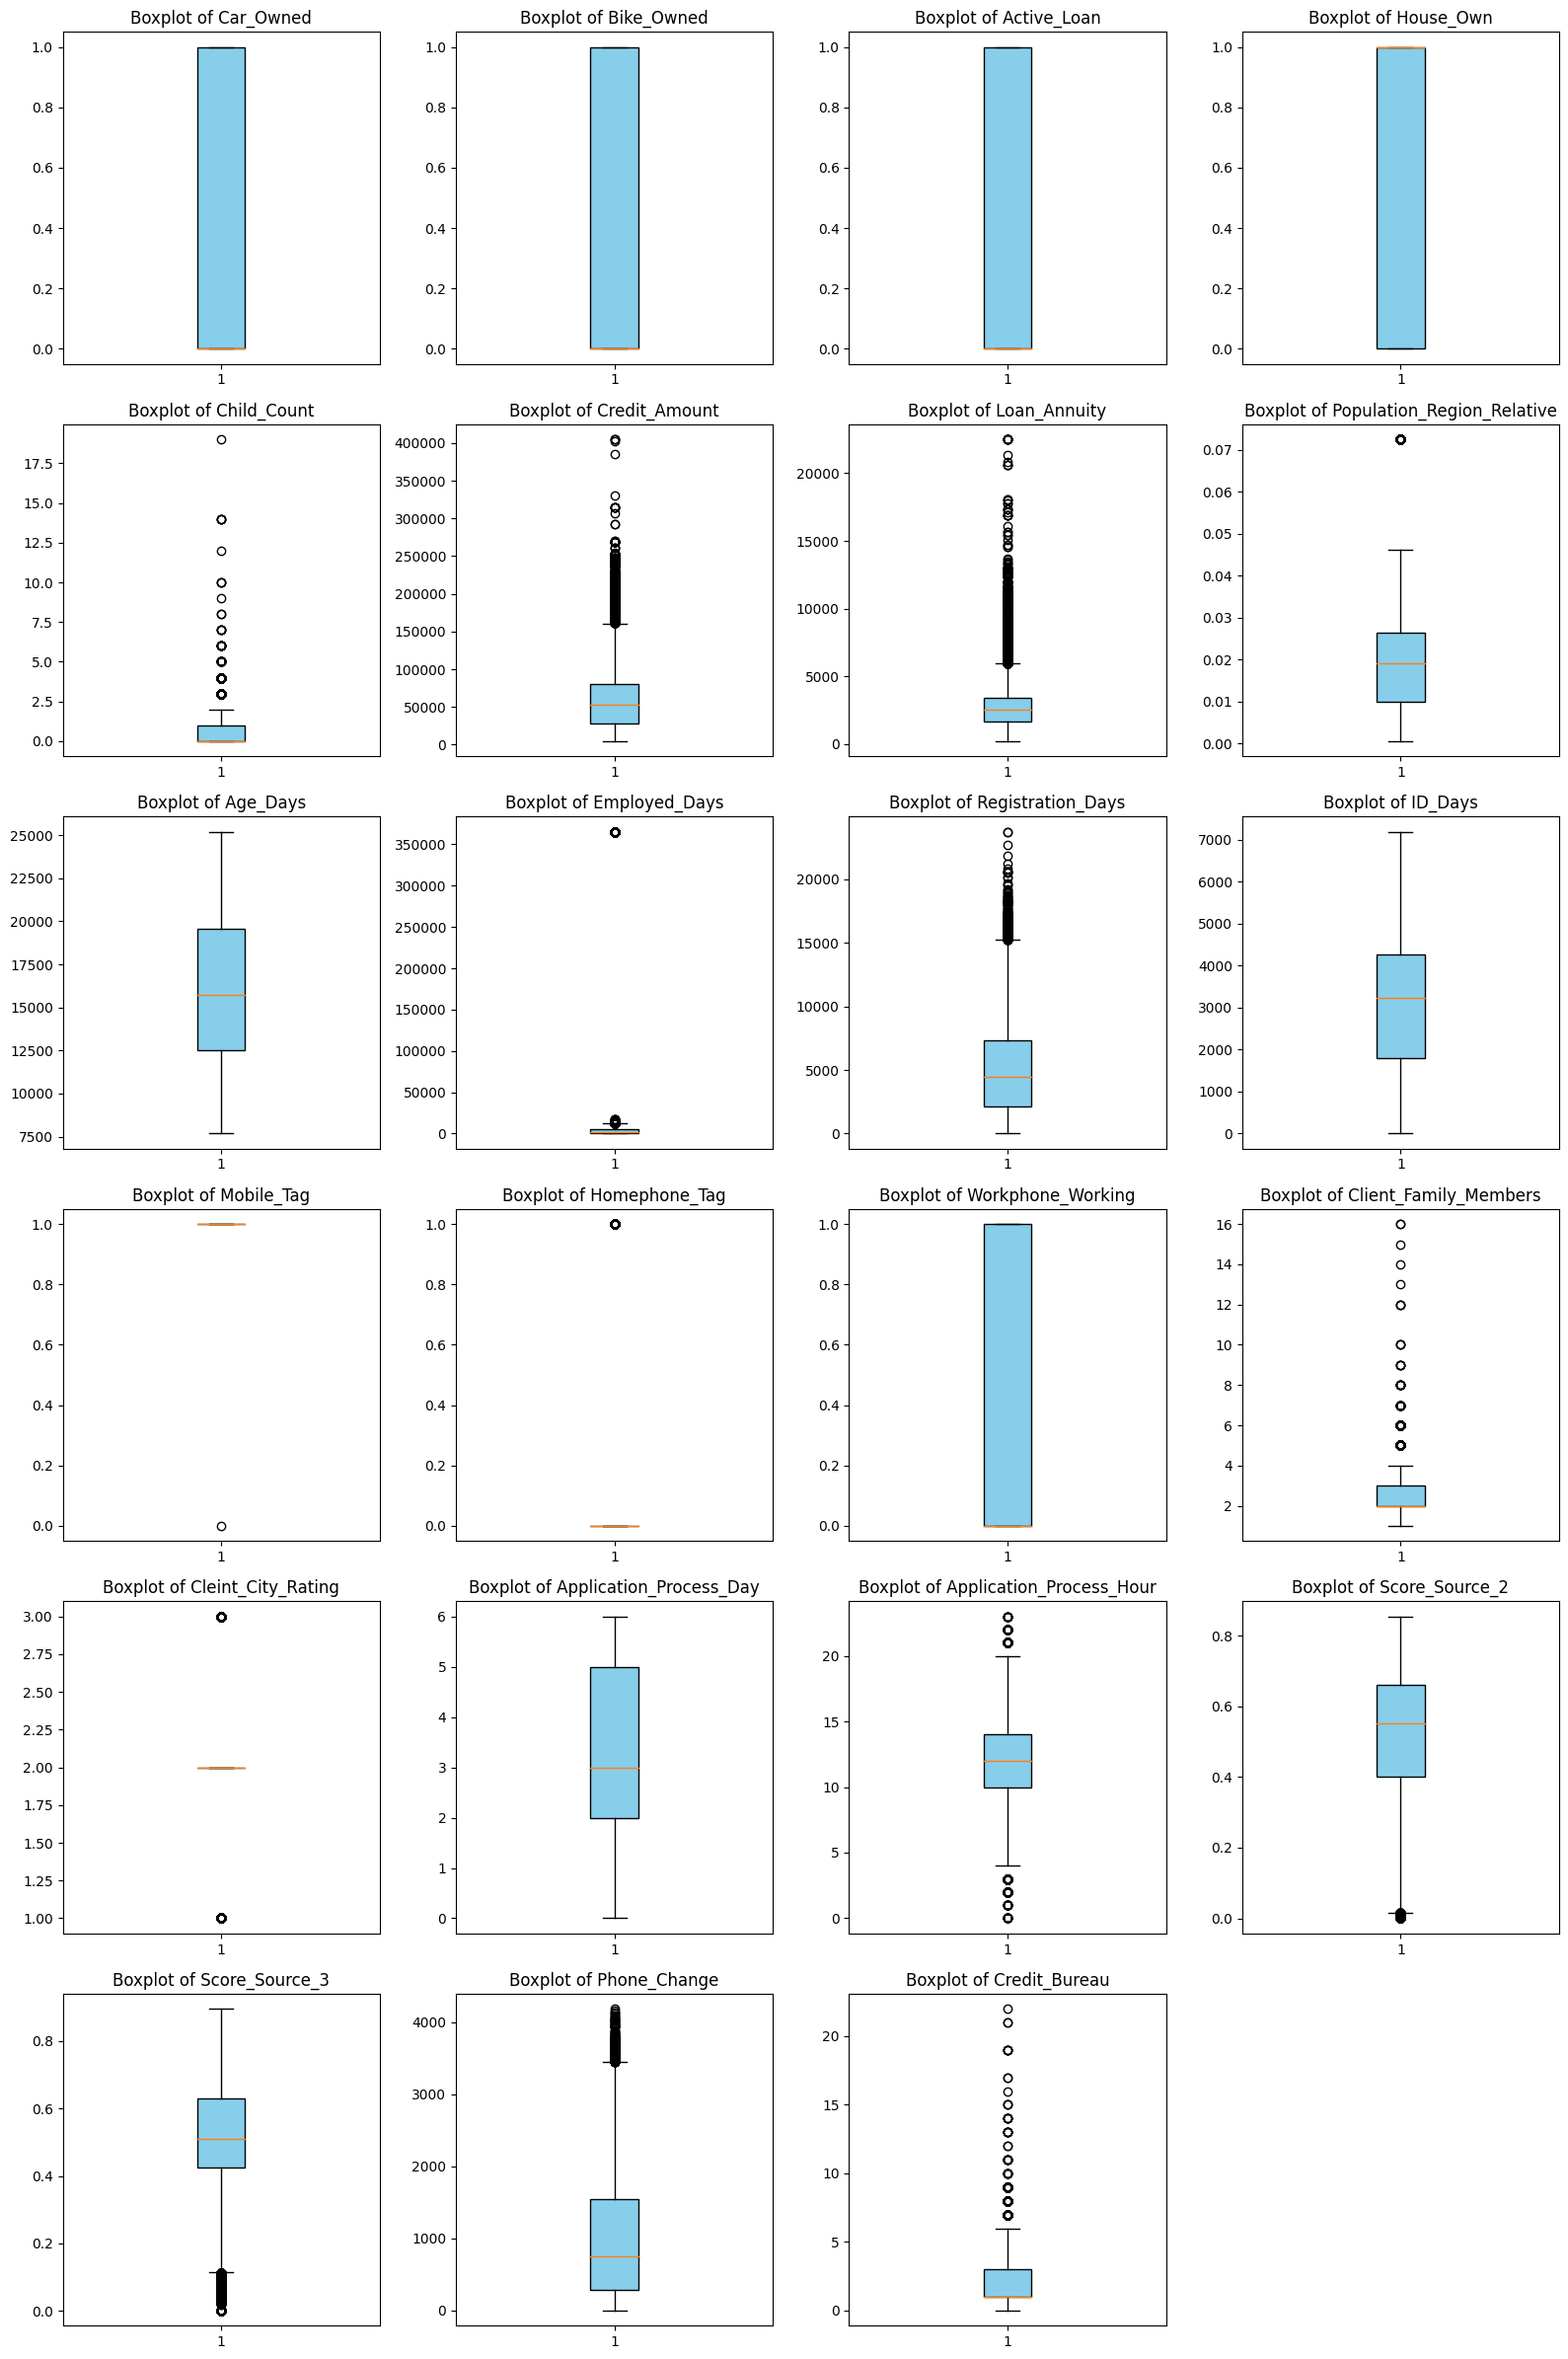

In [54]:
# Identify numeric columns
numeric_cols = data.select_dtypes(include=['number']).columns[1:]  # Exclude 'ID' column
numeric_data = data[numeric_cols]  # Subset numeric data

# Set up the grid layout for multiple boxplots
num_cols = len(numeric_cols)
rows = (num_cols // 4) + (num_cols % 4 > 0)  # Arrange in 4 columns

plt.figure(figsize=(16, rows * 4))  # Adjust figure size dynamically

# Plot boxplots for each numeric variable
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, 4, i)  # Define subplot grid
    plt.boxplot(numeric_data[col].dropna(), patch_artist=True, boxprops=dict(facecolor="skyblue"))
    plt.title(f"Boxplot of {col}")

plt.tight_layout()  # Adjust layout for better visualization
plt.show()

Variables with Outliers:

- Client_Income: Significant outliers with very high values, indicating income inequality among clients.
- Credit_Amount: Wide range with outliers representing large loan requests.
- Loan_Annuity: A few extreme values, likely due to incorrect or edge-case entries.
- Registration_Days: Outliers representing unusual registration timing.
- Phone_Change: Outliers indicate clients changing phones either very recently or a long time ago.
- Child COunt:  Few irregular entries we can see above 15 for ex. 
- SCore Source 3: Has some outliers in 25% 

Other Variables:

- Most variables (e.g., Car_Owned, Child_Count, Application_Process_Hour) have small ranges or are binary/discrete, so outliers aren't impactful or meaningful for treatment.

In [55]:
def treat_outliers_iqr(df, column):
    """
    Treat outliers in a specified column using the IQR method.
    Values outside the range [Q1 - 1.5*IQR, Q3 + 1.5*IQR] are capped.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
        column (str): The column name to treat outliers.
    
    Returns:
        pd.Series: The column with outliers capped.
    """
    Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range
    
    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap outliers
    return df[column].apply(
        lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x
    )

In [56]:
# Columns to treat
columns_to_treat = ["Client_Income", "Credit_Amount", "Child_Count", "Loan_Annuity", "Employed_Days", 
                    "Registration_Days", "Phone_Change", "Score_Source_3"]

# Apply IQR-based outlier treatment
for col in columns_to_treat:
    data[col] = treat_outliers_iqr(data, col)

## 2. Exploratory Data Analysis (EDA)

### 2.1 Univariate Analysis

#### 2.1.1 Numerical Columns

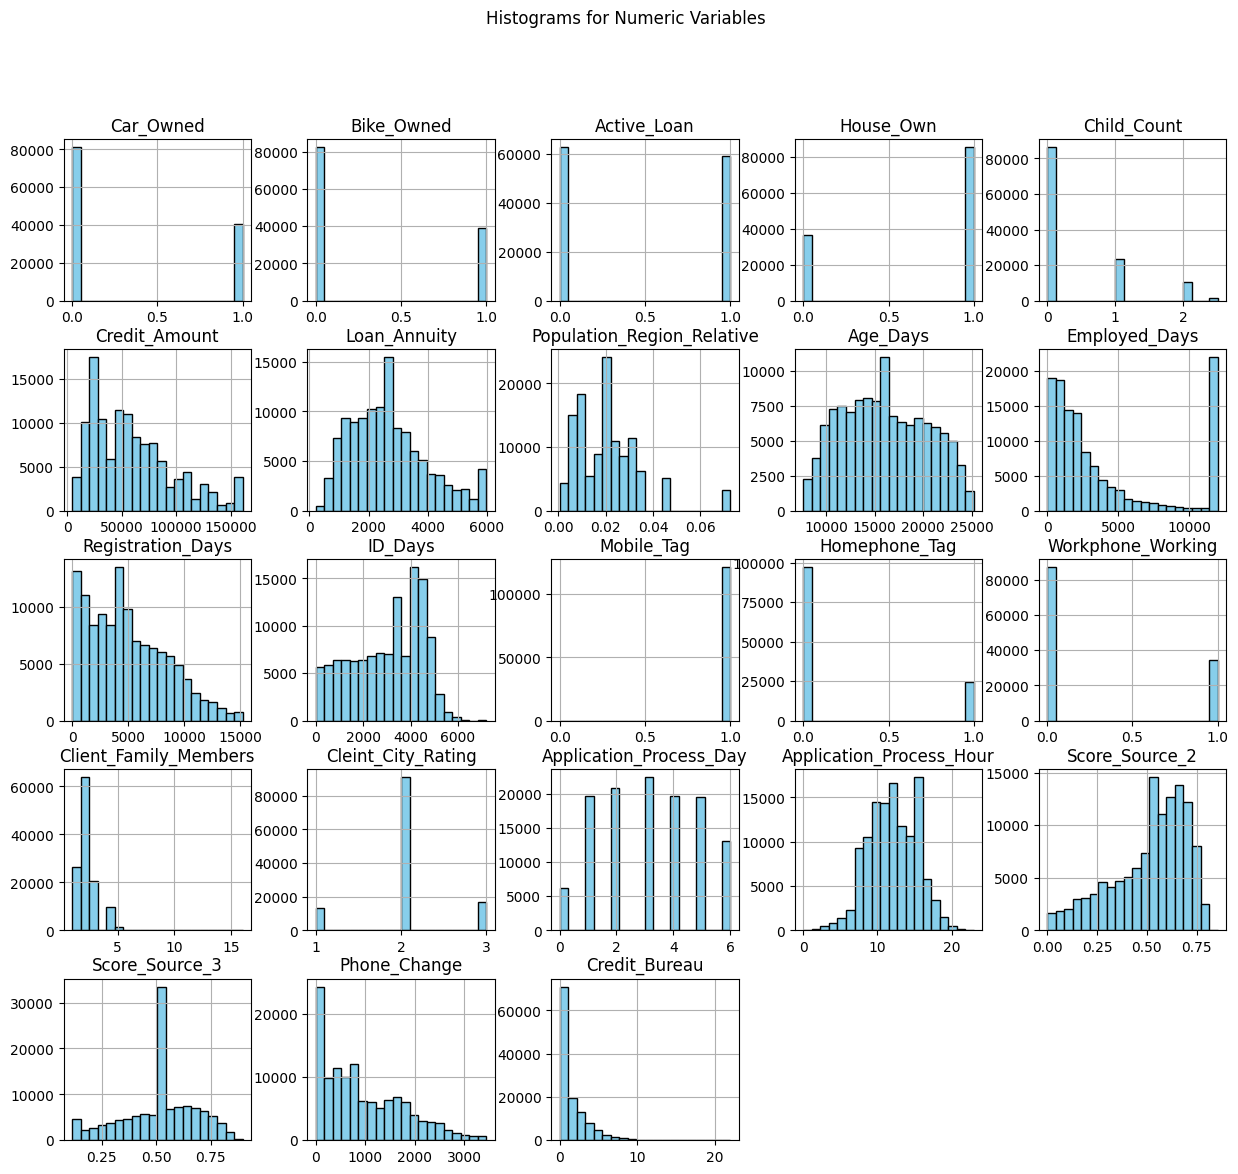

In [57]:
# Plot histograms for numeric variables
data[numeric_cols].hist(figsize=(15, 13), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Histograms for Numeric Variables")
plt.show()

In [58]:
categorical_cols = data.select_dtypes(include=['object']).columns[:-2] # Exclude 'Type_Organization' column which has lot of categories & 'Default' 
categorical_cols

Index(['Accompany_Client', 'Client_Income_Type', 'Client_Education',
       'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type',
       'Client_Housing_Type', 'Client_Permanent_Match_Tag',
       'Client_Contact_Work_Tag', 'Type_Organization'],
      dtype='object')

#### 2.1.2 Categorical Variables

In [59]:
def analyze_categorical_column(data, col, figsize=(10, 6), palette="viridis"):
    """
    Generate a bar plot for a categorical column and provide analysis.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        col (str): The column name to analyze.
        figsize (tuple): The size of the plot (default is (10, 6)).
        palette (str): The color palette for the bar plot.

    Returns:
        None: Displays the plot and prints the analysis.
    """
    if col not in data.columns:
        print(f"Column '{col}' not found in the dataset.")
        return
    
    # Analysis: Value counts and missing values
    print(f"\nAnalysis for '{col}':")
    print("-" * 50)
    print(f"Unique Categories: {data[col].nunique()}")
    print(f"Categories:\n{data[col].value_counts()}")
    print(f"Missing Values: {data[col].isnull().sum()} ({data[col].isnull().mean() * 100:.2f}%)")
    print("-" * 50)

    # Plot: Bar plot for the categorical column
    plt.figure(figsize=figsize)
    sns.countplot(data=data, x=col, palette=palette, order=data[col].value_counts().index)
    plt.title(f"Bar Plot of {col}")
    plt.xlabel(f"{col}")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [60]:
data.select_dtypes(include=['object']).columns

Index(['Accompany_Client', 'Client_Income_Type', 'Client_Education',
       'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type',
       'Client_Housing_Type', 'Client_Permanent_Match_Tag',
       'Client_Contact_Work_Tag', 'Type_Organization', 'ID', 'Default'],
      dtype='object')


Analysis for 'Client_Income_Type':
--------------------------------------------------
Unique Categories: 8
Categories:
Client_Income_Type
Service            64698
Commercial         27750
Retired            21033
Govt Job            8301
Student                8
Unemployed             6
Maternity leave        2
Businessman            1
Name: count, dtype: int64
Missing Values: 0 (0.00%)
--------------------------------------------------


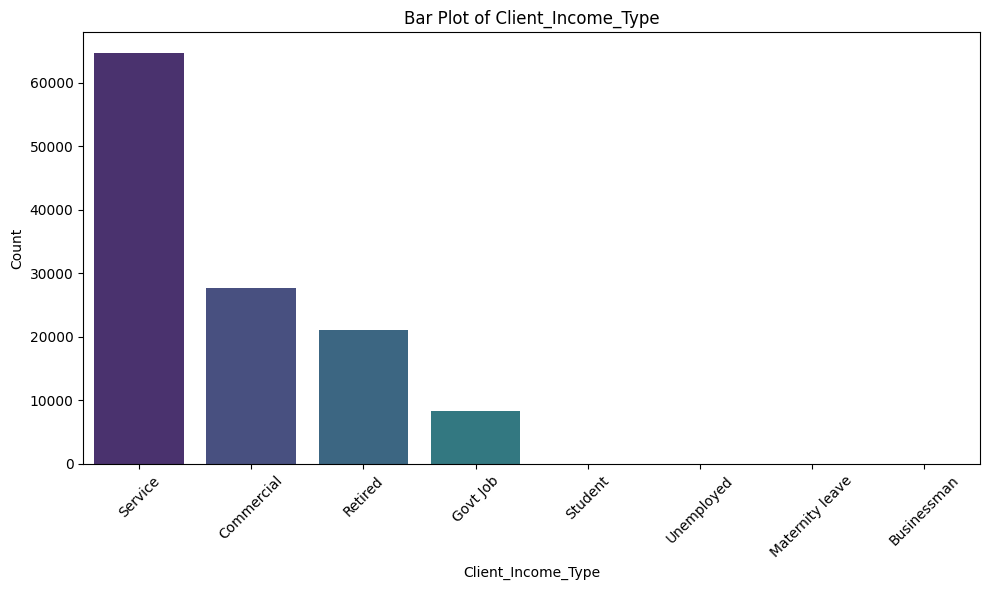

In [61]:
analyze_categorical_column(data, "Client_Income_Type")

The column Client_Income_Type contains 8 unique categories, but some categories (e.g., Student, Unemployed, Maternity leave, Businessman) have very few records. These rare categories might not provide significant value in modeling and could be grouped into a single category to reduce dimensionality.


Analysis for 'Accompany_Client':
--------------------------------------------------
Unique Categories: 7
Categories:
Accompany_Client
Alone       99108
Relative    15742
Partner      4513
Kids         1334
Others        987
Group         103
##             12
Name: count, dtype: int64
Missing Values: 0 (0.00%)
--------------------------------------------------


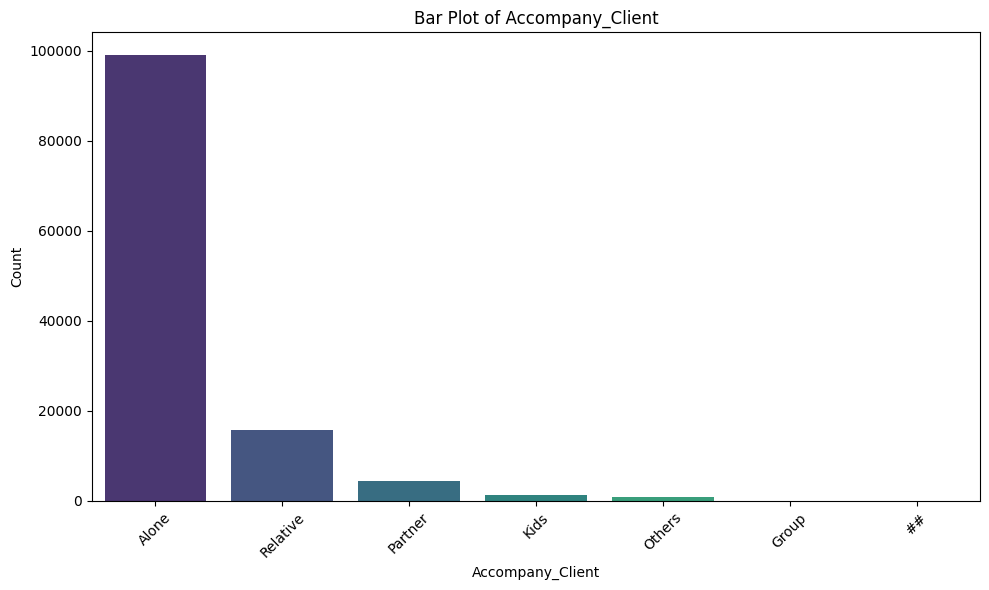

In [62]:
analyze_categorical_column(data, "Accompany_Client")

The column Accompany_Client has 7 unique categories, with the majority of clients applying alone (99,108) or with a relative (15,742). Rare categories like Group (103), Others (987), and invalid/placeholder values like ## (12) represent a small portion of the data and could be grouped into a single category, such as "Other", for simplification.


Analysis for 'Loan_Contract_Type':
--------------------------------------------------
Unique Categories: 2
Categories:
Loan_Contract_Type
CL    110714
RL     11085
Name: count, dtype: int64
Missing Values: 0 (0.00%)
--------------------------------------------------


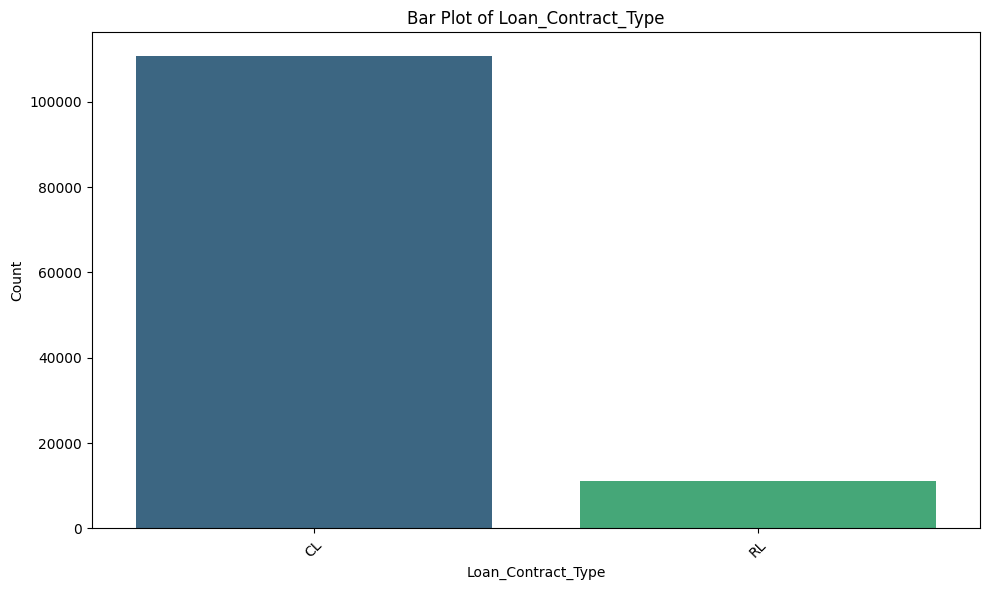

In [65]:
analyze_categorical_column(data, "Loan_Contract_Type")


Analysis for 'Default':
--------------------------------------------------
Unique Categories: 2
Categories:
Default
0    111958
1      9841
Name: count, dtype: int64
Missing Values: 0 (0.00%)
--------------------------------------------------


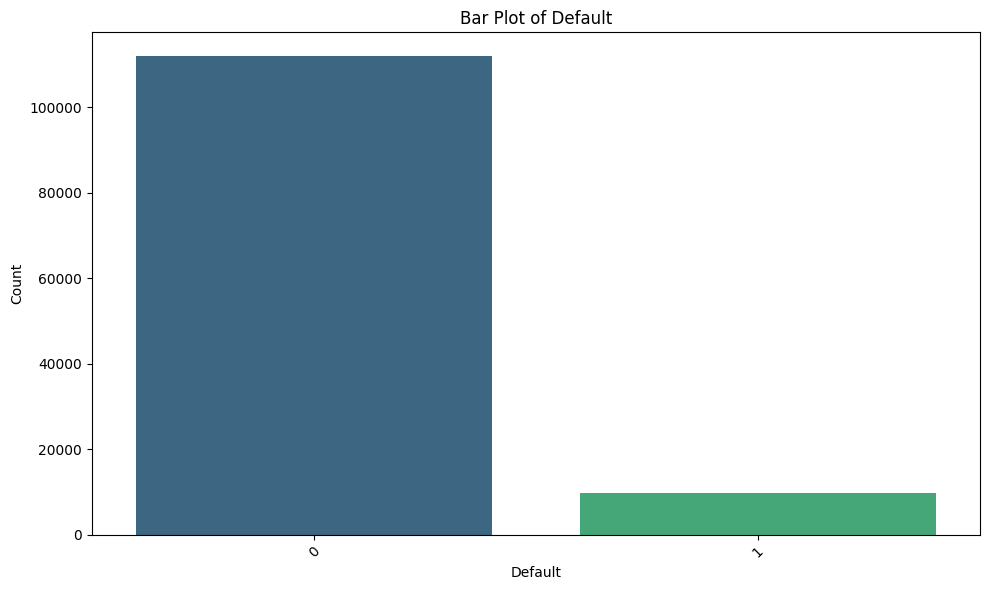

In [66]:
analyze_categorical_column(data, "Default")

The target variable Default is binary with two categories:

- 0 (No Default): 111,958 records (91.92%)
- 1 (Default): 9,841 records (8.08%)
The dataset is imbalanced, with a significantly larger proportion of clients who did not default compared to those who did. This imbalance may affect model performance and may require techniques like oversampling (e.g., SMOTE), undersampling, or class weighting to address it during modeling.


Analysis for 'Loan_Contract_Type':
--------------------------------------------------
Unique Categories: 2
Categories:
Loan_Contract_Type
CL    110714
RL     11085
Name: count, dtype: int64
Missing Values: 0 (0.00%)
--------------------------------------------------


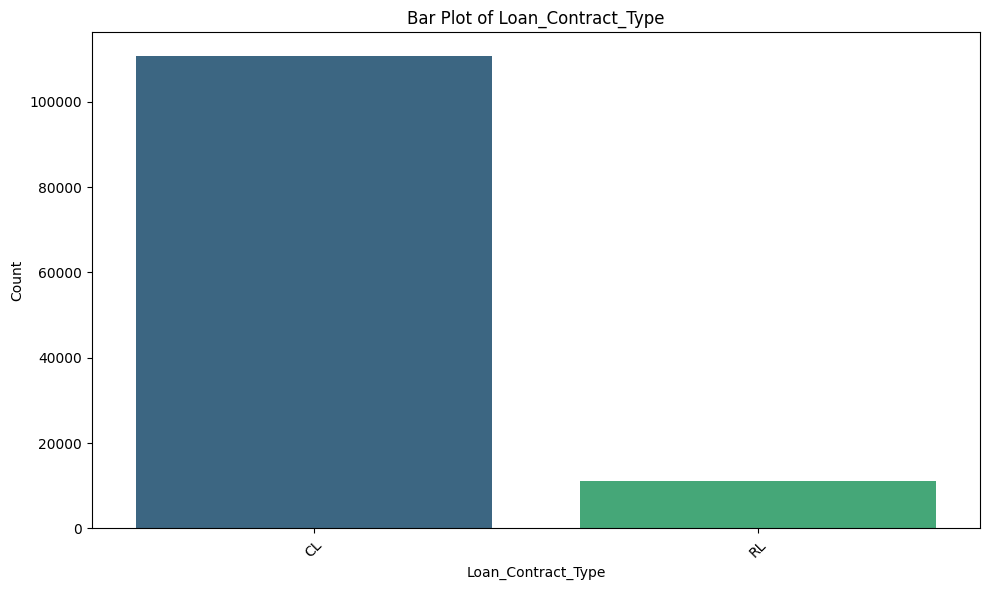

In [64]:
analyze_categorical_column(data, "Loan_Contract_Type")

## Data Processing

In [68]:
data.columns

Index(['Client_Income', 'Car_Owned', 'Bike_Owned', 'Active_Loan', 'House_Own',
       'Child_Count', 'Credit_Amount', 'Loan_Annuity', 'Accompany_Client',
       'Client_Income_Type', 'Client_Education', 'Client_Marital_Status',
       'Client_Gender', 'Loan_Contract_Type', 'Client_Housing_Type',
       'Population_Region_Relative', 'Age_Days', 'Employed_Days',
       'Registration_Days', 'ID_Days', 'Mobile_Tag', 'Homephone_Tag',
       'Workphone_Working', 'Client_Family_Members', 'Cleint_City_Rating',
       'Application_Process_Day', 'Application_Process_Hour',
       'Client_Permanent_Match_Tag', 'Client_Contact_Work_Tag',
       'Type_Organization', 'Score_Source_2', 'Score_Source_3', 'Phone_Change',
       'Credit_Bureau', 'ID', 'Default'],
      dtype='object')

In [69]:
data.shape

(121799, 36)